In [2]:
%%capture
import jax
import jax.numpy as np
from jax import grad
import diffrax
import pyccl as ccl
import matplotlib.pylab as plt
from typing import Any, Callable, Sequence, Tuple
from jax import jit

# jax_cosmo
from jax_cosmo.core import Cosmology
from jax_cosmo.background import H, Omega_m_a, Esqr
import jax_cosmo.background as bkgrd
from jax_cosmo.utils import a2z

plt.rc('text', usetex=True)
plt.rc('font',**{'family':'sans-serif','serif':['Palatino']})
figSize  = (12, 8)
fontSize = 12

In [3]:
cosmo_jax = Cosmology(Omega_c=0.25,
                      Omega_b=0.05,
                      h=0.7,
                      sigma8 = 0.8,
                      n_s=0.96,
                      Omega_k=0.,
                      w0=-1.,
                      wa=0.,
                     Neff = 3.044)

cosmo_ccl = ccl.Cosmology(Omega_c=0.25,
                          Omega_b=0.05,
                          h=0.7,
                          sigma8 = 0.8,
                          n_s=0.96,
                          w0=-1.0,
                          wa=0.,
                          Neff = 3.044,
                          transfer_function='eisenstein_hu',
                          matter_power_spectrum='halofit')

In [3]:
A_MIN = -2.5
STEPS = int(1024*10)

print(f"Maximum redshift is {a2z(10**A_MIN):.2f}")

Maximum redshift is 315.23


In [4]:
def grad_H(cosmo: Cosmology, a: float) -> Any:
    """
    Computes the gradient of the function H with respect to its second argument (index 1).

    Parameters:
        cosmo (Cosmology): A parameter or object representing cosmological data or settings.
        a (float): A scalar value representing the second argument to the function H.

    Returns:
        Any: The gradient of H with respect to the second argument evaluated at (cosmo, a).
    """
    return grad(H, argnums=1)(cosmo, a)

def alpha_beta(cosmo: Cosmology, a: float) -> np.ndarray:
    """
    Computes the alpha and beta values and returns a 2x2 matrix based on the given cosmological parameters.

    Args:
        cosmo (Cosmology): Cosmological parameters or model object required for calculations.
        a (float): The scale factor (a positive scalar value representing cosmological time scaling).

    Returns:
        np.ndarray: A 2x2 NumPy array containing the computed alpha and beta values:
            [[0.0, 1.0],
             [-beta, -alpha]]

    Notes:
        - `grad_H(cosmo, a)` computes the gradient of the Hubble function `H` with respect to its arguments.
        - `Omega_m_a(cosmo, a)` calculates the matter density parameter at scale factor `a`.
        - `H(cosmo, a)` is the Hubble parameter at the scale factor `a`.
    """
    gH_over_H = grad_H(cosmo, a) / H(cosmo, a)
    alpha = 5.0 / a + gH_over_H
    beta = 3 / a**2 + gH_over_H / a - 1.5 * Omega_m_a(cosmo, a) / a**2
    return np.array([[0.0, 1.0], [-beta, -alpha]])

def cash_karp_method(
    func: Callable[[np.ndarray, float], np.ndarray],
    y0: np.ndarray,
    t: Sequence[float]
) -> np.ndarray:
    """
    Solves an ordinary differential equation (ODE) using the Cash-Karp Runge-Kutta method.

    Args:
        func (Callable[[np.ndarray, float], jnp.ndarray]):
            A function that defines the system of ODEs. It takes the current value `y`
            (state vector) and time `t` as input and returns the derivative `dy/dt`.
        y0 (np.ndarray):
            The initial condition (state vector) at the starting time.
        t (Sequence[float]):
            A sequence of time steps at which the solution is evaluated.

    Returns:
        np.ndarray:
            A NumPy-like array containing the approximate solution of the ODE at each time step.

    Notes:
        - The Cash-Karp method is a fifth-order Runge-Kutta method that provides an
          efficient way to solve ODEs with adaptive step sizes. However, this implementation
          uses fixed step sizes defined by `t`.
        - `jax.lax.scan` is used for efficient iterative computations with JAX.
    """

    def cash_karp(carry: Tuple[np.ndarray, float], t: float) -> Tuple[Tuple[np.ndarray, float], np.ndarray]:
        """
        One iteration of the Cash-Karp method.

        Args:
            carry (Tuple[np.ndarray, float]):
                A tuple containing the current state vector `y` and the previous time step `t_prev`.
            t (float):
                The next time step.

        Returns:
            Tuple[Tuple[np.ndarray, float], np.ndarray]:
                A tuple where the first element is the updated state `(y, t)` and
                the second element is the updated state `y` for the current step.
        """
        y, t_prev = carry
        h = t - t_prev  # Step size
        k1 = func(y, t_prev)
        k2 = func(y + h * k1 / 5, t_prev + 0.2 * h)
        k3 = func(y + h * (3 * k1 / 40 + 9 * k2 / 40), t_prev + 0.3 * h)
        k4 = func(y + h * (3 * k1 / 10 - 9 * k2 / 10 + 6 * k3 / 5), t_prev + 0.6 * h)
        k5 = func(y + h * (-11 * k1 / 54 + 5 * k2 / 2 - 70 * k3 / 27 + 35 * k4 / 27), t_prev + h)
        k6 = func(
            y + h * (
                1631 * k1 / 55296 + 175 * k2 / 512 + 575 * k3 / 13824 +
                44275 * k4 / 110592 + 253 * k5 / 4096
            ),
            t_prev + 0.875 * h
        )
        y = y + h * (37 * k1 / 378 + 250 * k3 / 621 + 125 * k4 / 594 + 512 * k6 / 1771)
        return (y, t), y

    # Perform the iterative computation over the time steps using jax.lax.scan
    (yf, _), y = jax.lax.scan(cash_karp, (y0, np.array(t[0])), t)
    return y

def euler_method(
    func: Callable[[np.ndarray, float], np.ndarray],
    y0: np.ndarray,
    t: Sequence[float]
) -> np.ndarray:
    """
    Solves an ordinary differential equation (ODE) using the Euler method.

    Args:
        func (Callable[[np.ndarray, float], np.ndarray]):
            A function that defines the system of ODEs. It takes the current state `y`
            and time `t` as input and returns the derivative `dy/dt`.
        y0 (np.ndarray):
            The initial condition (state vector) at the starting time.
        t (Sequence[float]):
            A sequence of time steps at which the solution is to be evaluated.

    Returns:
        np.ndarray:
            A NumPy-like array containing the approximate solution of the ODE at each time step.

    Notes:
        - The Euler method is a first-order numerical method for solving ODEs.
        - `jax.lax.scan` is used to efficiently compute the solution iteratively.
    """

    def euler(carry: Tuple[np.ndarray, float], t: float) -> Tuple[Tuple[np.ndarray, float], np.ndarray]:
        """
        One iteration of the Euler method.

        Args:
            carry (Tuple[jnp.ndarray, float]):
                A tuple containing the current state vector `y` and the previous time step `t_prev`.
            t (float):
                The next time step.

        Returns:
            Tuple[Tuple[jnp.ndarray, float], jnp.ndarray]:
                A tuple where the first element is the updated state `(y, t)` and
                the second element is the updated state `y` for the current step.
        """
        y, t_prev = carry
        h = t - t_prev  # Step size
        k1 = func(y, t_prev)  # Derivative at the current step
        y = y + h * k1  # Update state using Euler's formula
        return (y, t), y

    # Perform the iterative computation over time steps using jax.lax.scan
    (yf, _), y = jax.lax.scan(euler, (y0, np.array(t[0])), t)
    return y

def growth_factor_calculation(
    cosmo: Cosmology,
    log10_amin: float = -2.0,
    steps: int = 1024,
    method: str = 'euler'
) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    """
    Computes the growth factor, growth rate, and related quantities for a cosmological model.

    Args:
        cosmo (Cosmology):
            An instance of the `Cosmology` class containing cosmological parameters.
        log10_amin (float, optional):
            The base-10 logarithm of the minimum scale factor. Defaults to -2.0.
        steps (int, optional):
            The number of steps in the scale factor array. Higher values increase precision. Defaults to 1024.
        method (str, optional):
            The numerical method to use for solving the growth ODEs.
            Options are 'euler' (Euler method) or 'cash-karp' (Cash-Karp method). Defaults to 'euler'.

    Returns:
        Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
            - `atab` (np.ndarray): The scale factor array (logarithmically spaced).
            - `growth_rate` (np.ndarray): The growth rate of the perturbations at each scale factor.
            - `growth_factor` (np.ndarray): The normalized growth factor at each scale factor.
            - `y_record` (np.ndarray): The full solution of the ODE system, containing perturbation values.

    Notes:
        - The function solves a system of ordinary differential equations (ODEs) for cosmological growth
          using either the Euler or Cash-Karp numerical methods.
        - The growth rate is derived as: `growth_rate = (a * y[:,1] / y[:,0]) + 1`.
        - The growth factor is normalized so that its final value is 1 at the present scale factor `a = 1`.
    """

    # Define the scale factor array (logarithmically spaced)
    atab = np.logspace(log10_amin, 0.0, steps)
    y0 = np.array([1.0, 0.0])  # Initial condition for the growth factor system

    # Define the system of ODEs for the growth factor
    def g_derivs(y: np.ndarray, x: float) -> np.ndarray:
        """
        Computes the derivative of the growth system.

        Args:
            y (np.ndarray):
                The state vector of the growth system at a given scale factor.
            x (float):
                The current scale factor.

        Returns:
            np.ndarray: The time derivative of the state vector.
        """
        return alpha_beta(cosmo, x) @ y

    # Solve the system using the specified numerical method
    if method == 'euler':
        y_record = euler_method(g_derivs, y0, atab)
    elif method == 'cash-karp':
        y_record = cash_karp_method(g_derivs, y0, atab)
    else:
        raise ValueError("Invalid method specified. Use 'euler' or 'cash-karp'.")

    # Calculate the growth rate
    growth_rate = (atab * y_record[:, 1] / y_record[:, 0]) + 1.0

    # Calculate the normalized growth factor
    growth_factor = atab * y_record[:, 0]
    growth_factor /= growth_factor[-1]  # Normalize to 1 at a = 1

    return atab, growth_rate, growth_factor, y_record

## Calculation


In [5]:
atab, gr_euler, gf_euler, g_record_euler = growth_factor_calculation(cosmo_jax,
                                                                     log10_amin=A_MIN,
                                                                     steps=STEPS,
                                                                     method = 'euler')

atab, gr_ck, gf_ck, g_record_ck = growth_factor_calculation(cosmo_jax,
                                                            log10_amin=A_MIN,
                                                            steps=STEPS,
                                                            method = 'cash-karp')

gr_jax = bkgrd.growth_rate(cosmo_jax, atab)
gr_ccl = cosmo_ccl.growth_rate(atab)

gf_jax = bkgrd.growth_factor(cosmo_jax, atab)
gf_ccl = cosmo_ccl.growth_factor(atab)

## Plot


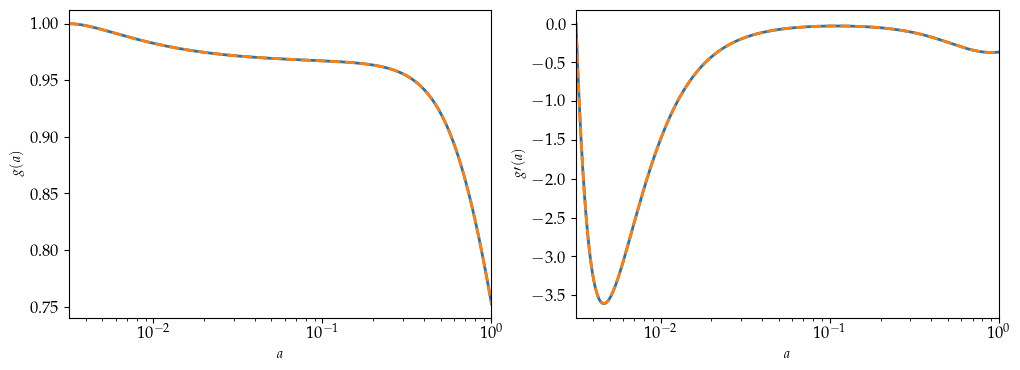

In [6]:
plt.figure(figsize = (12,4))
plt.subplot(121)
plt.plot(atab, g_record_euler[:,0], lw = 2)
plt.plot(atab, g_record_ck[:,0], lw = 2, linestyle = '--')
plt.xscale('log')
plt.xlabel(r'$a$')
plt.ylabel(r'$g(a)$')
plt.tick_params(axis='x', labelsize=fontSize)
plt.tick_params(axis='y', labelsize=fontSize)
plt.xlim(min(atab), max(atab))

plt.subplot(122)
plt.plot(atab, g_record_euler[:,1], lw = 2)
plt.plot(atab, g_record_ck[:,1], lw = 2, linestyle = '--')
plt.xscale('log')
plt.xlabel(r'$a$')
plt.ylabel(r'$g\prime(a)$')
plt.tick_params(axis='x', labelsize=fontSize)
plt.tick_params(axis='y', labelsize=fontSize)
plt.xlim(min(atab), max(atab))

plt.show()

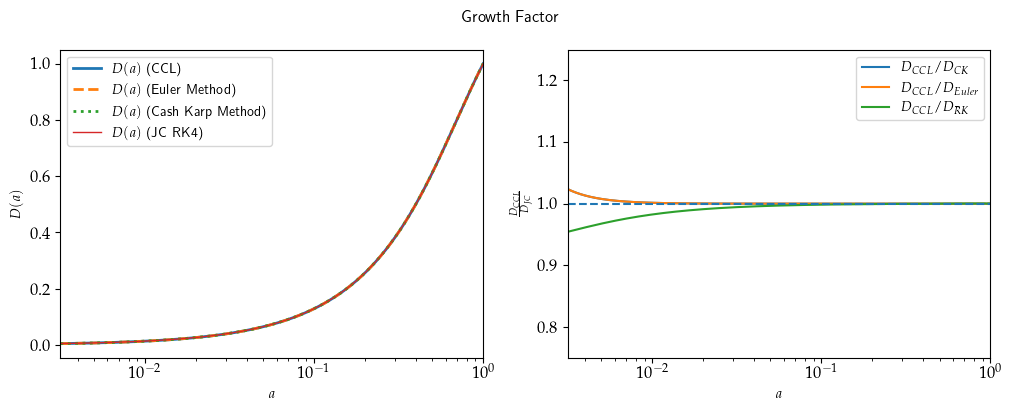

In [7]:
plt.figure(figsize = (12,4))
plt.suptitle('Growth Factor')
plt.subplot(121)
plt.plot(atab, gf_ccl, lw = 2, label = r'$D(a)$ (CCL)')
plt.plot(atab, gf_euler, lw = 2, linestyle = '--', label = r'$D(a)$ (Euler Method)')
plt.plot(atab, gf_ck, lw = 2, linestyle = ':', label = r'$D(a)$ (Cash Karp Method)')
plt.plot(atab, gf_jax, lw = 1, label = r'$D(a)$ (JC RK4)')
plt.xlabel(r'$a$')
plt.ylabel(r'$D(a)$')
plt.xscale('log')
plt.tick_params(axis='x', labelsize=fontSize)
plt.tick_params(axis='y', labelsize=fontSize)
plt.xlim(min(atab), max(atab))
plt.legend()
plt.subplot(122)
plt.plot(atab, gf_ccl / gf_ck, label = '$D_{CCL}/D_{CK}$')
plt.plot(atab, gf_ccl / gf_euler, label = '$D_{CCL}/D_{Euler}$')
plt.plot(atab, gf_ccl / gf_jax, label = '$D_{CCL}/D_{RK}$')
plt.axhline(1, linestyle = '--')
plt.ylim(0.75, 1.25)
plt.xlabel(r'$a$')
plt.xscale('log')
plt.ylabel(r'$\frac{D_{CCL}}{D_{JC}}$')
plt.tick_params(axis='x', labelsize=fontSize)
plt.tick_params(axis='y', labelsize=fontSize)
plt.xlim(min(atab), max(atab))
plt.legend()
plt.show()

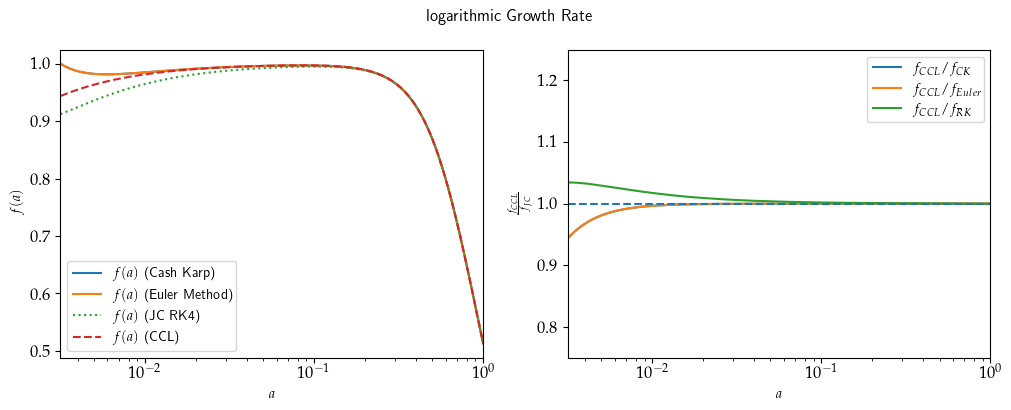

In [8]:
plt.figure(figsize = (12,4))
plt.suptitle('logarithmic Growth Rate')
plt.subplot(121)
plt.plot(atab, gr_ck, label = '$f(a)$ (Cash Karp)')
plt.plot(atab, gr_euler, label = '$f(a)$ (Euler Method)')
plt.plot(atab, gr_jax, linestyle = ':', label = '$f(a)$ (JC RK4)')
plt.plot(atab, gr_ccl, linestyle = '--', label = '$f(a)$ (CCL)')
plt.xlabel(r'$a$')
plt.ylabel(r'$f(a)$')
plt.xscale('log')
plt.tick_params(axis='x', labelsize=fontSize)
plt.tick_params(axis='y', labelsize=fontSize)
plt.xlim(min(atab), max(atab))
plt.legend()
plt.subplot(122)
plt.plot(atab, gr_ccl / gr_ck, label = '$f_{CCL}/f_{CK}$')
plt.plot(atab, gr_ccl / gr_euler, label = '$f_{CCL}/f_{Euler}$')
plt.plot(atab, gr_ccl / gr_jax, label = '$f_{CCL}/f_{RK}$')
plt.axhline(1, linestyle = '--')
plt.ylim(0.75, 1.25)
plt.xlabel(r'$a$')
plt.xscale('log')
plt.ylabel(r'$\frac{f_{CCL}}{f_{JC}}$')
plt.tick_params(axis='x', labelsize=fontSize)
plt.tick_params(axis='y', labelsize=fontSize)
plt.xlim(min(atab), max(atab))
plt.legend()
plt.show()